# Remote Sensing Modeling with Unsupervised Learning

This Jupyter Notebook demonstrates the application of unsupervised machine learning methods for land cover classification using **LandSat 8** satellite imagery. The methods used include:
- **K-Means Clustering**: Groups pixels into predefined clusters based on spectral similarity.
- **Gaussian Mixture Model (GMM)**: Uses probabilistic clustering for smooth transitions between regions.
- **HDBSCAN**: A density-based clustering approach that detects complex land cover patterns.

## Objectives
- Preprocess and visualize **LandSat 8** spectral bands.
- Apply clustering methods to identify distinct ground cover types.
- Compare results across different clustering algorithms.

---

Image deconstruction to compare all pixels together

In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np

files = list(os.walk("data/"))

columns_of_interest = [
    "Satellite",
    "Correction",
    "WRS",
    "Acquisition Date",
    "Processing Date",
    "Collection",
    "Category",
    "Pixel",
    "Column",
    "Band",
    "Value"
]

# Gather all the pixels of each band and label them for the next step
image_dataframe = pd.DataFrame(columns=columns_of_interest)
for file in files[0][2]:
    print(file)
    is_tiff = file.split(".")[-1] == "TIF"
    if is_tiff:
        file_contents = file.split("_")
        band = file_contents[7].split(".")[0]
        image_pil = Image.open("/".join(["data", file]))
        image_array = np.array(image_pil)

        rows_to_process = image_array.shape[0]//20 # adjust divider to use more pixels
        columns_to_process = image_array.shape[1]//20
        
        image_array = image_array[-rows_to_process:, :columns_to_process]
        image_array = pd.DataFrame(image_array, columns=list(range(image_array.shape[1])), index=list(range(image_array.shape[0])))

        image_melted = image_array.melt().reset_index() # this makes each pixel a different row
        image_melted.columns = ["Pixel", "Column", "Value"]

        image_melted["Satellite"] = file_contents[0]
        image_melted["Correction"] = file_contents[1]
        image_melted["WRS"] = file_contents[2]
        image_melted["Acquisition Date"] = file_contents[3]
        image_melted["Processing Date"] = file_contents[4]
        image_melted["Collection"] = file_contents[5]
        image_melted["Category"] = file_contents[6]
        image_melted["Band"] = band

        image_dataframe = pd.concat([image_dataframe, image_melted])

# Take all the bands and transpose them so one pixel is in a row with all its band information
pixels_grouped = image_dataframe.groupby(by=columns_of_interest[:-2])["Value"].apply(lambda df: df.reset_index(drop=True)).unstack()
pixels_grouped.columns = list(np.add(list(range(7)), 1))
pixels_grouped.reset_index(inplace=True)
print(pixels_grouped.shape)

# Remove faulty readings where the data is all zeroes
all_zeroes = [1] * pixels_grouped.shape[0]
for i in range(1, 8, 1):
    all_zeroes = np.logical_and(all_zeroes, pixels_grouped[i] == 0)
pixels_grouped.loc[all_zeroes] = np.nan 
pixels_grouped = pixels_grouped.dropna()
print(pixels_grouped.shape)



LC08_CU_002008_20181108_20210503_02_SR_B1.TIF
LC08_CU_002008_20181108_20210503_02_SR_B2.TIF
LC08_CU_002008_20181108_20210503_02_SR_B3.TIF
LC08_CU_002008_20181108_20210503_02_SR_B4.TIF
LC08_CU_002008_20181108_20210503_02_SR_B5.TIF
LC08_CU_002008_20181108_20210503_02_SR_B6.TIF
LC08_CU_002008_20181108_20210503_02_SR_B7.TIF
(62500, 16)
(62500, 16)


Visualize Data as a pairplot to get an idea of correlations

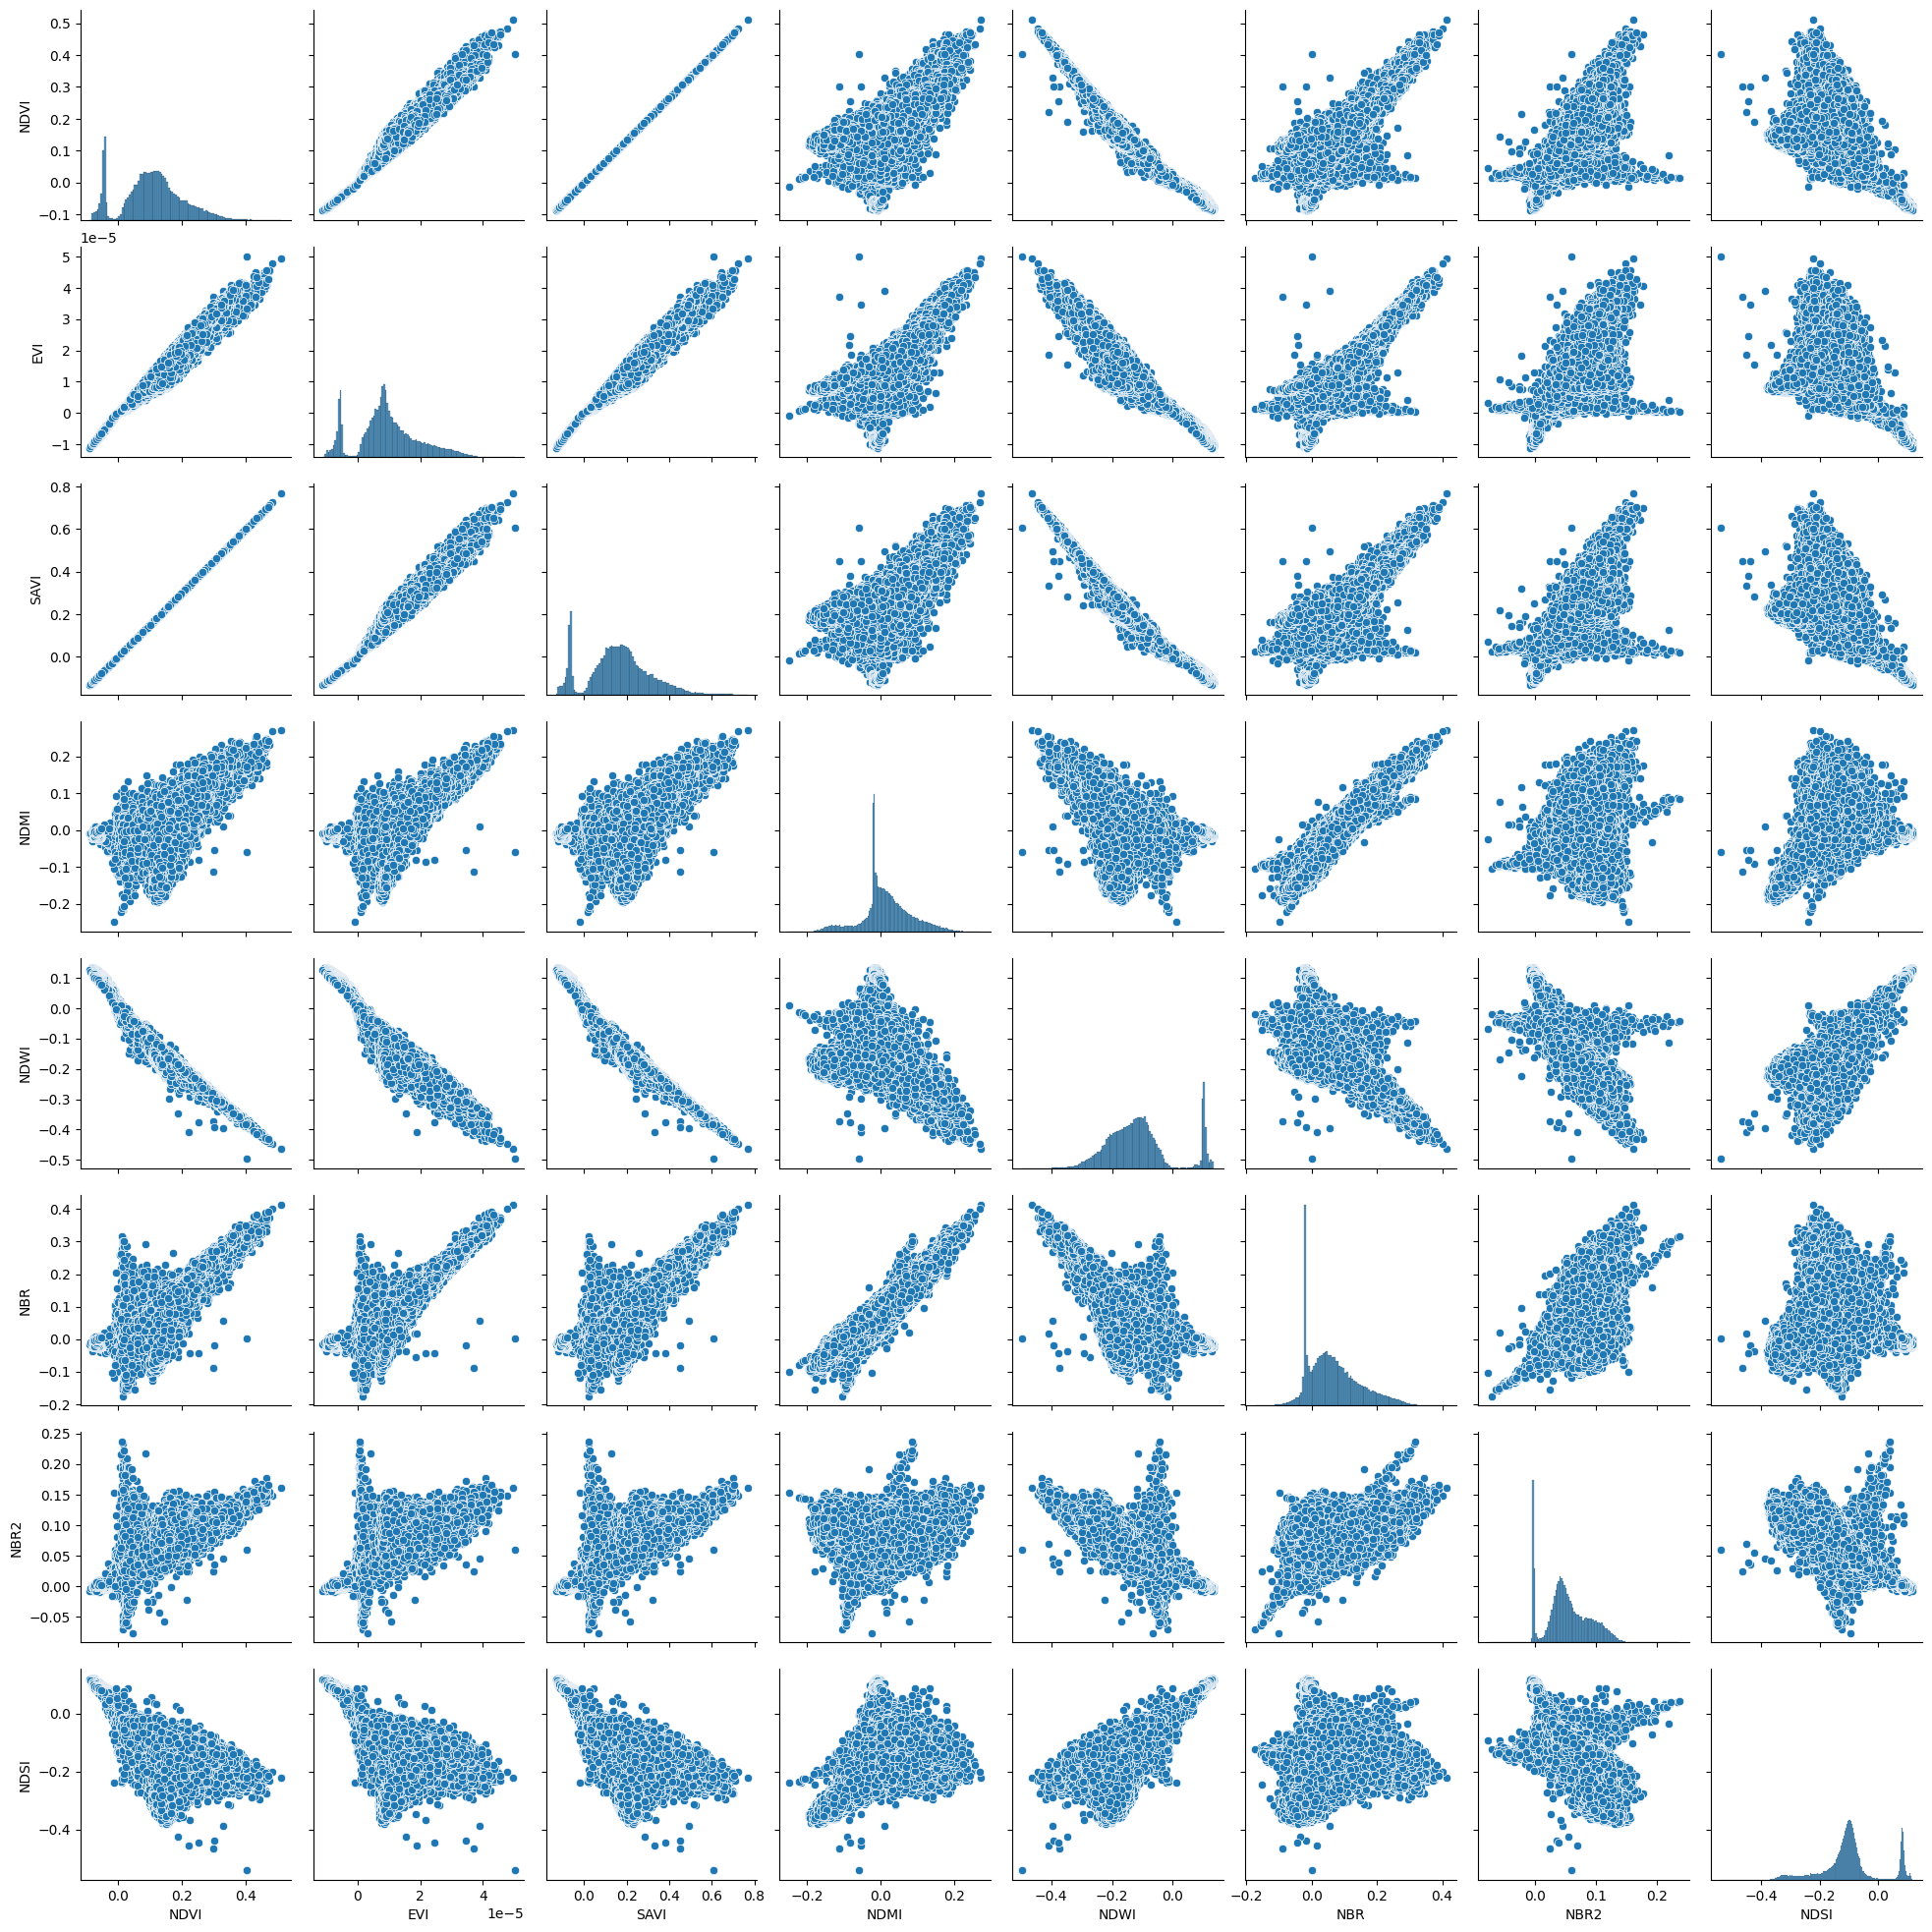

In [2]:
import seaborn

# Domain Knowledge
# https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices

pixels_grouped["NDVI"] = (pixels_grouped[5] - pixels_grouped[4]) / (pixels_grouped[5] + pixels_grouped[4])
pixels_grouped["EVI"] = (pixels_grouped[5] - pixels_grouped[4]) / ((pixels_grouped[5] + pixels_grouped[6]) * pixels_grouped[4] - 7.5 * (pixels_grouped[2] + pixels_grouped[1]))
pixels_grouped["SAVI"] = (pixels_grouped[5] - pixels_grouped[4]) / (pixels_grouped[5] + pixels_grouped[4] + 0.5) * 1.5
pixels_grouped["NDMI"] = (pixels_grouped[5] - pixels_grouped[6]) / (pixels_grouped[5] + pixels_grouped[6])
pixels_grouped["NDWI"] = (pixels_grouped[3] - pixels_grouped[5]) / (pixels_grouped[3] + pixels_grouped[5])
pixels_grouped["NBR"] = (pixels_grouped[5] - pixels_grouped[7]) / (pixels_grouped[5] + pixels_grouped[7])
pixels_grouped["NBR2"] = (pixels_grouped[6] - pixels_grouped[7]) / (pixels_grouped[6] + pixels_grouped[7])
pixels_grouped["NDSI"] = (pixels_grouped[3] - pixels_grouped[6]) / (pixels_grouped[3] + pixels_grouped[6])

domain_columns = [
    "NDVI",
    "EVI",
    "SAVI",
    "NDMI",
    "NDWI",
    "NBR",
    "NBR2",
    "NDSI",
]

seaborn.pairplot(pixels_grouped[domain_columns])

band_scaled_data = pixels_grouped[domain_columns]

### Model Construction

### K-Means

K-Means clustering is a widely used, effective method for unsupervised classification of satellite imagery. In the context of remote sensing, it offers several key advantages:

#### 1. **Simplicity and Computational Efficiency**
- **K-Means is computationally lightweight** and scales well to large datasets, such as high-resolution satellite images containing millions of pixels.
- Its simplicity allows for **rapid processing and analysis**, making it ideal for handling the vast amount of data captured by platforms like LandSat 8.

#### 2. **Unsupervised Learning**
- **Remote sensing data is often unlabeled**, especially when covering broad or inaccessible geographic regions.
- K-Means operates in an **unsupervised manner**, clustering data points based solely on the spectral similarity of their features (e.g., reflectance values across different bands), without the need for ground truth labels.

#### 3. **Captures Spectral Similarity**
- Each pixel in satellite imagery has reflectance values across multiple spectral bands.
- **K-Means minimizes Euclidean distance** between pixels and cluster centroids, effectively grouping pixels with similar spectral signatures.
- This allows for the natural separation of land cover types such as:
  - Forests
  - Water bodies
  - Urban areas
  - Dry regions
  - Snow or ice-covered regions

#### 4. **Interpretability**
- The output is highly interpretable:
  - Each pixel is assigned a specific cluster (label).
  - The cluster centers represent the **average spectral signature** of each land cover type, which can be analyzed further.
- This makes K-Means useful for **visualizing and understanding land cover distribution patterns**.

#### 5. **Provides a Strong Baseline**
- K-Means offers a reliable **baseline model** for land cover classification.
- Results can serve as a reference point for:
  - Fine-tuning cluster parameters.
  - Applying more complex clustering techniques (e.g., Gaussian Mixture Models or HDBSCAN).
  - Informing supervised classification tasks.

---

#### **Limitations to Consider:**
While K-Means is highly practical, it has some limitations:
- Requires **predefining the number of clusters (`k`)**, which may not always be straightforward.
- Assumes **spherical, evenly sized clusters**, which might not match the irregular patterns of natural land cover.
- Sensitive to **initial centroid placement**, potentially leading to varying results.


In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

inertia = []
silhouette_scores = []

param_grid = {
    'n_clusters': range(2, 15),
    'n_init': [50],
    'max_iter': [500],
}

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    kmeans = KMeans(**params, random_state=42)
    labels = kmeans.fit_predict(band_scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(band_scaled_data, labels))


Testing parameters: {'max_iter': 500, 'n_clusters': 2, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 3, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 4, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 5, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 6, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 7, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 8, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 9, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 10, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 11, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 12, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 13, 'n_init': 50}
Testing parameters: {'max_iter': 500, 'n_clusters': 14, 'n_init': 50}


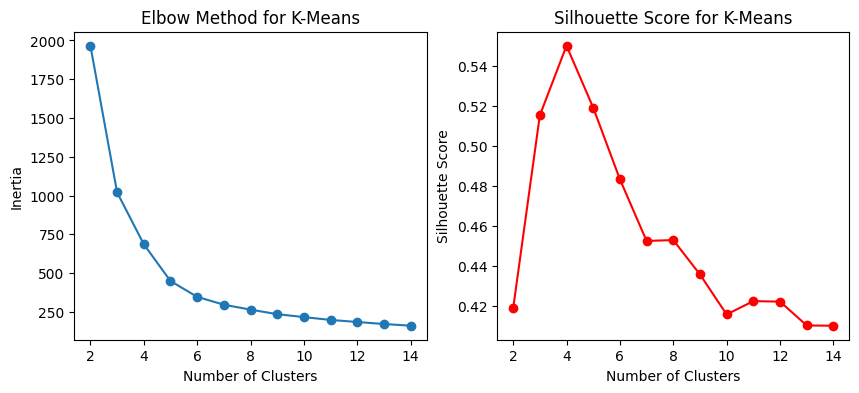

In [4]:
# Plot the Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(list(range(2,15)), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(list(range(2,15)), silhouette_scores, marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means')

plt.show()


### Gaussian Mixture Models

**Gaussian Mixture Models (GMM)** are an advanced probabilistic clustering technique that extends the functionality of K-Means. GMM offers several advantages for remote sensing applications:

#### 1. **Probabilistic Nature and Soft Clustering**
- Unlike K-Means, which assigns each data point to a single cluster, GMM provides **soft cluster assignments**.
- Each pixel is assigned a probability of belonging to each cluster.
- This is valuable for **transition zones** (e.g., forest edges, urban sprawl) where boundaries between land cover types are not clear-cut.

#### 2. **Flexibility in Cluster Shape**
- **GMM does not assume spherical clusters** like K-Means.
- It models each cluster as a multivariate Gaussian distribution, allowing for **elliptical and irregular shapes**.
- This is well-suited to natural land cover patterns, which may vary significantly in size, orientation, and distribution.

#### 3. **Handles Overlapping Clusters**
- Environmental features often overlap spectrally (e.g., wet soil vs. water bodies).
- GMM can capture these overlaps by providing probability distributions instead of hard labels.

#### 4. **Interpretability and Scalability**
- Each Gaussian component can be analyzed to understand its mean spectral signature and covariance, offering deeper insights into:
  - Vegetation types
  - Water regions
  - Urban areas
  - Snow/ice cover

---

### **Limitations to Consider:**
- Requires **predefining the number of components (`n_components`)**.
- Can be **sensitive to initialization**, though this is mitigated with multiple restarts.
- Computationally heavier than K-Means, especially for large datasets.


Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 2, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 3, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 4, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 5, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 6, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 7, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 8, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 9, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 10, 'n_init': 10}
Testing parameters: {'covariance_type': 'full', 'max_iter': 300, 'n_components': 11, 'n_init': 10}
Testing parameters

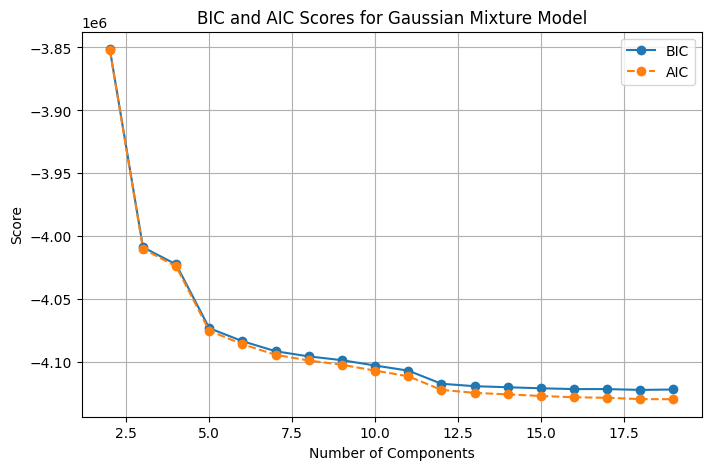

In [5]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid

# Initialize lists to store evaluation metrics
bic_scores = []
aic_scores = []

# Define range of component numbers to test

param_grid = {
    'n_components': range(2, 20),
    'covariance_type': ['full'],
    'n_init': [10],
    'max_iter': [300]
}

# Iterate over component numbers
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    gmm = GaussianMixture(**params, random_state=42)
    gmm.fit(band_scaled_data)
    
    # Compute BIC and AIC scores
    bic_scores.append(gmm.bic(band_scaled_data))
    aic_scores.append(gmm.aic(band_scaled_data))

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(list(range(2, 20)), bic_scores, marker='o', label='BIC')
plt.plot(list(range(2, 20)), aic_scores, marker='o', linestyle="dashed", label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for Gaussian Mixture Model')
plt.legend()
plt.grid(True)
plt.show()


### Hierarchical Density-Based Spatial Clustering of Applications with Noise

**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** is an advanced density-based clustering method, well-suited for complex remote sensing data.

#### 1. **Automatic Cluster Number Determination**
- Unlike K-Means and GMM, HDBSCAN **does not require predefining the number of clusters**.
- It automatically identifies dense regions and separates noise (e.g., clouds, sensor artifacts).

#### 2. **Handles Irregular Cluster Shapes**
- HDBSCAN excels at finding clusters of **varying shapes, densities, and sizes**, making it ideal for natural environments (forests, urban areas, water bodies) that don't conform to geometric shapes.

#### 3. **Noise Detection**
- HDBSCAN can effectively label pixels that don't belong to any significant cluster as **noise**.
- This is particularly useful in remote sensing for filtering out:
  - Cloud cover artifacts
  - Unclassified pixels
  - Sensor noise

#### 4. **No Need for k Specification**
- Eliminates the need to specify `k` (number of clusters), reducing the risk of human bias in parameter selection.

---

#### **Limitations to Consider:**
- Sensitive to parameters like **`min_cluster_size`** and **`min_samples`**.
- Can label too many points as noise if parameters are too strict.
- Computationally more intensive than K-Means.

In [6]:
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import itertools
import numpy as np

# Define parameter grid
param_grid = {
    'min_cluster_size': [20, 50, 100, 200],
    'min_samples': [10, 50, 100, 200],
    'cluster_selection_method': ['leaf'],
    'metric': ['euclidean']
}

best_score = -1
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    hdb = HDBSCAN(**params)
    labels = hdb.fit_predict(band_scaled_data)
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise
    print(f"Number of clusters found: {num_clusters}")
    
    # Only compute Silhouette Score if valid (more than 1 cluster)
    if num_clusters > 1:
        score = silhouette_score(band_scaled_data, labels)
        print(f"Silhouette Score: {score}")
        
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = labels

print("\nBest Parameters Found:", best_params)
print("Best Silhouette Score:", best_score)

# Assign labels
pixels_grouped["HDBSCAN"] = best_labels


Testing parameters: {'cluster_selection_method': 'leaf', 'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 10}
Number of clusters found: 92
Silhouette Score: -0.8164314578464866
Testing parameters: {'cluster_selection_method': 'leaf', 'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 50}
Number of clusters found: 24
Silhouette Score: -0.7733511443979398
Testing parameters: {'cluster_selection_method': 'leaf', 'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 100}
Number of clusters found: 10
Silhouette Score: -0.4746928208715126
Testing parameters: {'cluster_selection_method': 'leaf', 'metric': 'euclidean', 'min_cluster_size': 20, 'min_samples': 200}
Number of clusters found: 8
Silhouette Score: -0.201729431155424
Testing parameters: {'cluster_selection_method': 'leaf', 'metric': 'euclidean', 'min_cluster_size': 50, 'min_samples': 10}
Number of clusters found: 28
Silhouette Score: -0.7505538630556259
Testing parameters: {'cluster_selection_method': '

Regenerate images based on the clusters found

Text(0.5, 1.0, 'HDBScan')

<Figure size 1200x1200 with 0 Axes>

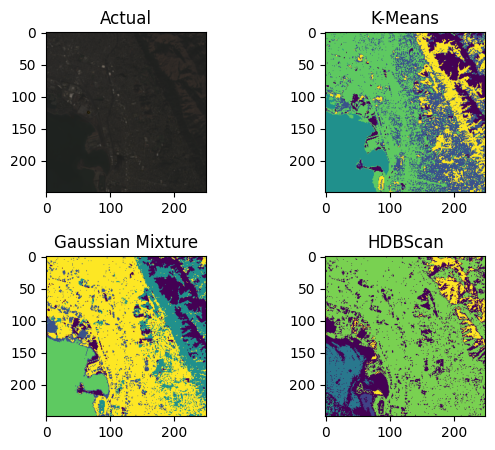

In [7]:

import matplotlib.pyplot as plt

best_model = GaussianMixture(n_components=5, covariance_type='full', n_init=50, max_iter=500, random_state=42)
labels = best_model.fit_predict(band_scaled_data)
pixels_grouped["GMM"] = labels

best_model = KMeans(n_clusters=5, n_init=50, max_iter=500, random_state=42)
labels = best_model.fit_predict(band_scaled_data)
pixels_grouped["Kmeans"] = labels

kmeans_image = np.subtract(np.zeros(image_array.shape), 2)
gmm_image = np.subtract(np.zeros(image_array.shape), 2)
hdbscan_image = np.subtract(np.zeros(image_array.shape), 2)
r_image = np.subtract(np.zeros(image_array.shape), 2)
g_image = np.subtract(np.zeros(image_array.shape), 2)
b_image = np.subtract(np.zeros(image_array.shape), 2)
for label_id, pixel_id in enumerate(pixels_grouped.index):
    col_id = int(pixels_grouped["Column"][pixel_id])
    row_id = pixel_id - (col_id * len(image_array[1]))
    kmeans_image[row_id, col_id] = pixels_grouped["Kmeans"][pixel_id]
    gmm_image[row_id, col_id] = pixels_grouped["GMM"][pixel_id]
    hdbscan_image[row_id, col_id] = pixels_grouped["HDBSCAN"][pixel_id]
    r_image[row_id, col_id] = pixels_grouped[4][pixel_id]
    g_image[row_id, col_id] = pixels_grouped[3][pixel_id]
    b_image[row_id, col_id] = pixels_grouped[2][pixel_id]

rgb_image = np.dstack([r_image, g_image, b_image])
rgb_image = np.divide(rgb_image, 65535)

plt.figure(figsize=(12, 12))
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(left=0.1, right=0.9, 
                    top=0.9, bottom=0.1, 
                    wspace=0.2, hspace=0.4)
axs[0, 0].imshow(rgb_image)
axs[0, 0].set_title("Actual")
axs[0, 1].imshow(kmeans_image)
axs[0, 1].set_title("K-Means")
axs[1, 0].imshow(gmm_image)
axs[1, 0].set_title("Gaussian Mixture")
axs[1, 1].imshow(hdbscan_image)
axs[1, 1].set_title("HDBScan")